## Lab: Grammar-Aware Re-Ranking generated text with a PCFG

Objective
- Build and parse with a small PCFG for Nepali SOV word order.
- Compute sentence log-probabilities under a PCFG.
- Re-rank the best hypothesis

### Setup

In [1]:
import math
from typing import List, Dict, Tuple
import nltk
from nltk import PCFG, Nonterminal
from nltk.parse import ViterbiParser

print("NLTK version:", nltk.__version__)

NLTK version: 3.9.1


### Define the tiny PCFG

Encode a minimal SOV grammar with postpositions (ergative “-ले”, dative “लाई”). Probabilities are toy values but plausible.

In [3]:
grammar_txt = r"""
S -> NPERG NPACC V [1.0]

# Noun phrases
NPERG -> PRON_ERG [0.6] | NERG [0.4]
NPACC -> N [0.6] | N LAI [0.4]

# Lexicon (very small for the lab)
PRON_ERG -> 'उसले' [0.6] | 'हामीले' [0.4]
NERG     -> 'विद्यार्थीले' [0.5] | 'बालकले' [0.5]
N        -> 'कुकुर' [0.5] | 'पत्र' [0.5]
LAI      -> 'लाई' [1.0]
V        -> 'देख्यो' [0.6] | 'ल्यायो' [0.4]
"""

In [4]:
G = PCFG.fromstring(grammar_txt)
parser = ViterbiParser(G)

In [ ]:
!pip install svgling

['उसले', 'कुकुर', 'देख्यो']
(S (NPERG (PRON_ERG उसले)) (NPACC (N कुकुर)) (V देख्यो)) (p=0.0648)


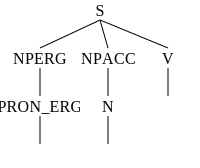

In [6]:
sent = "उसले कुकुर देख्यो"
tokens = sent.split()
print(tokens)
parsed = list(parser.parse(tokens))
print(parsed[0])
parsed[0]

### Compute the log prob

Return the best (Viterbi) parse log-probability under the PCFG in natural log.


If unparseable, return a large negative penalty.

In [10]:
def pcfg_logprob(tokens):
    try:
        parses = list(parser.parse(tokens))
        # print(parses[0])
        if not parses:
            return -1e9
        return parses[0].logprob()
    except ValueError:
        # thrown if some token is out of the grammar's vocabulary
        return -1e9

In [12]:
pcfg_logprob("उसले कुकुर देख्यो".split())

-3.9478623766648253

In [13]:
examples = [
    "उसले कुकुर देख्यो",
    "हामीले पत्र ल्यायो",
    "उसले कुकुर लाई ल्यायो",   # NPACC -> N LAI (OK)
    "कुकुर उसले देख्यो",       # OSV (should be penalized / often unparseable)
]
for s in examples:
    print(f"{s} => pcfg_logprob={pcfg_logprob(s.split())}")

उसले कुकुर देख्यो => pcfg_logprob=-3.9478623766648253
हामीले पत्र ल्यायो => pcfg_logprob=-5.1177873781071375
उसले कुकुर लाई ल्यायो => pcfg_logprob=-5.1177873781071375
कुकुर उसले देख्यो => pcfg_logprob=-1000000000.0


### Re-Rank Generated Candidates

We’ll simulate a generator (LLM or simple LM) that provides multiple candidates and an internal model log-prob for each. The PCFG will provide a grammar log-prob, and we’ll combine them.

In [14]:
Dataset = []

data: Dataset = [
    {
        "prompt": "Describe who saw the dog (SOV).",
        "candidates": [
            {"text": "उसले कुकुर देख्यो",        "model_logp": -5.10},
            {"text": "कुकुर उसले देख्यो",        "model_logp": -4.90},  # better model score, wrong order
            {"text": "उसले कुकुर लाई देख्यो",    "model_logp": -5.00},  # grammatical with dative
        ],
    },
    {
        "prompt": "Who brought the letter (SOV)?",
        "candidates": [
            {"text": "हामीले पत्र ल्यायो",        "model_logp": -6.00},
            {"text": "पत्र हामीले ल्यायो",        "model_logp": -5.60},  # OSV
            {"text": "हामीले पत्र लाई ल्यायो",    "model_logp": -5.70},  # OK, with dative object
        ],
    },
    {
        "prompt": "Who saw the letter (SOV)?",
        "candidates": [
            {"text": "विद्यार्थीले पत्र देख्यो",   "model_logp": -5.90},
            {"text": "पत्र विद्यार्थीले देख्यो",   "model_logp": -5.40},  # OSV
            {"text": "विद्यार्थीले पत्र लाई देख्यो","model_logp": -5.50},  # OK
        ],
    },
]


**Scoring rule**

We combine the generator’s score with a PCFG score:

$$Score(candidate) = \alpha \times model\_logp + γ \times logP_{PCFG}(candidate)$$

In [17]:
def rank_with_grammar(cands: List[Dict[str, object]], α: float = 1.0, γ: float = 0.2):
    """
    Return candidates sorted by combined score: α * model_logp + γ * pcfg_logprob.
    Highest score is best (note: both are log-probs, i.e., negative numbers typically).
    """
    scored = []
    for c in cands:
        lp_model = float(c["model_logp"])
        lp_pcfg  = pcfg_logprob(str(c["text"]).split())
        c = dict(c)  # copy
        c["pcfg_logp"] = lp_pcfg
        c["score"] = α*lp_model + γ*lp_pcfg
        scored.append(c)
    return sorted(scored, key=lambda d: d["score"], reverse=True)

def rank_baseline(cands: List[Dict[str, object]]):
    """Baseline: choose purely by model log-prob."""
    return sorted(cands, key=lambda d: d["model_logp"], reverse=True)

**Run the experiment**

In [19]:
def pretty_print(prompt: str, ranked: List[Dict[str, object]], head: str):
    print(f"\n=== {head} ===")
    print("Prompt:", prompt)
    for i, r in enumerate(ranked, 1):
        print(f"{i:>2}. {r['text']}  | model_logp={r['model_logp']:.2f}  "
              f"| pcfg_logp={r.get('pcfg_logp', float('nan')):.2f}  | score={r.get('score', float('nan')):.2f}")

# Compare baseline vs grammar-aware ranking for γ in {0, 0.1, 0.2, 0.4}
gammas = [0.0, 0.1, 0.2, 0.4]
for gamma in gammas:
    print("\n" + "#"*70)
    print(f"# Gamma = {gamma}")
    print("#"*70)
    for item in data:
        base = rank_baseline(item["candidates"])
        gram = rank_with_grammar(item["candidates"], α=1.0, γ=gamma)
        pretty_print(item["prompt"], base, head="Baseline (model only)")
        pretty_print(item["prompt"], gram, head=f"With PCFG (γ={gamma})")


######################################################################
# Gamma = 0.0
######################################################################

=== Baseline (model only) ===
Prompt: Describe who saw the dog (SOV).
 1. कुकुर उसले देख्यो  | model_logp=-4.90  | pcfg_logp=nan  | score=nan
 2. उसले कुकुर लाई देख्यो  | model_logp=-5.00  | pcfg_logp=nan  | score=nan
 3. उसले कुकुर देख्यो  | model_logp=-5.10  | pcfg_logp=nan  | score=nan

=== With PCFG (γ=0.0) ===
Prompt: Describe who saw the dog (SOV).
 1. कुकुर उसले देख्यो  | model_logp=-4.90  | pcfg_logp=-1000000000.00  | score=-4.90
 2. उसले कुकुर लाई देख्यो  | model_logp=-5.00  | pcfg_logp=-4.53  | score=-5.00
 3. उसले कुकुर देख्यो  | model_logp=-5.10  | pcfg_logp=-3.95  | score=-5.10

=== Baseline (model only) ===
Prompt: Who brought the letter (SOV)?
 1. पत्र हामीले ल्यायो  | model_logp=-5.60  | pcfg_logp=nan  | score=nan
 2. हामीले पत्र लाई ल्यायो  | model_logp=-5.70  | pcfg_logp=nan  | score=nan
 3. हामीले पत्र ल्यायो  |

## Assignment
Use LLM model to generate the top-n sentences and rank them based on the grammer.

Language: English or Nepali
